# FFT Analysis

This notebook is meant for analysing `.wav` samples with Python. The `preview` function allows easy inspection of audio files by plotting graphs of amplitude against time and frequency.

In [56]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfft2, rfftfreq
from scipy.io import wavfile

In [57]:
# plot amplitude against time and amplitude against frequency graphs
def preview(
    filename,
    bits_per_sample=8,
    amplitude_range=(0, 1000),
    frequency_range=(0, 1000),
):
    display.display(display.Audio(filename))

    sample_rate, data = wavfile.read(filename)
    num_samples = len(data)
    num_channels = 1 if len(data.shape) == 1 else data.shape[1]
    duration = num_samples / sample_rate

    x1 = np.linspace(0, duration, num_samples, endpoint=False)
    y1 = (data / 255 * 2 - 1) if bits_per_sample == 8 else data / 32768 # normalize values

    x2 = rfftfreq(num_samples, 1 / sample_rate)
    y2 = rfft2(y1) if num_channels == 2 else rfft(y1)

    # amplitude against time
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.title("Amplitude against Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized amplitude")
    plt.axhline(0, linestyle='--').set_color('black')
    begin, end = amplitude_range 
    plt.plot(x1[begin: end], y1[begin:end])

    # amplitude against frequency bins
    plt.subplot(1, 2, 2)
    plt.title("Amplitude against Frequency")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized amplitude")
    begin, end = frequency_range 
    plt.plot(x2[begin:end], np.abs(y2[begin:end]))

    plt.show()

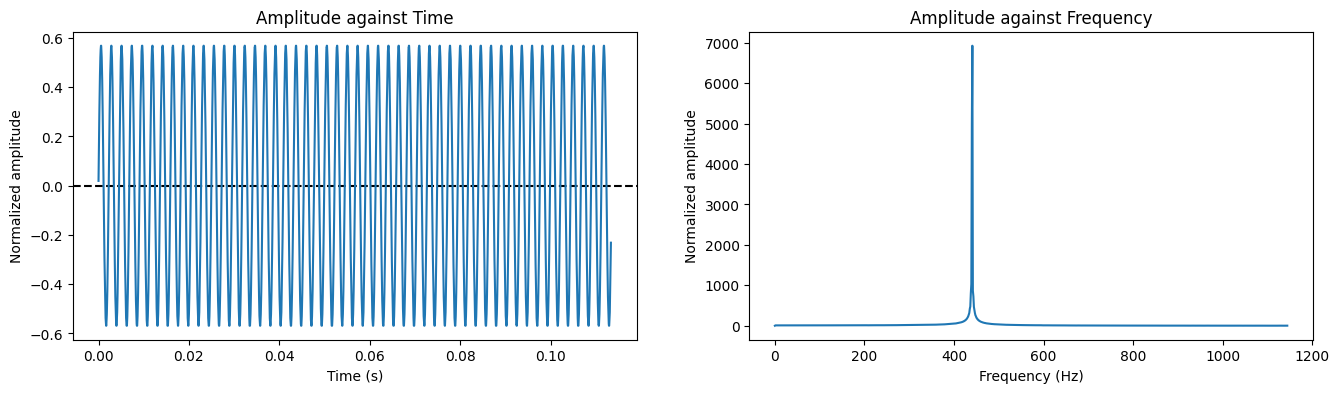

In [58]:
preview("samples/8-bit.wav", amplitude_range=(0, 5000))

Shifted by -1 steps:


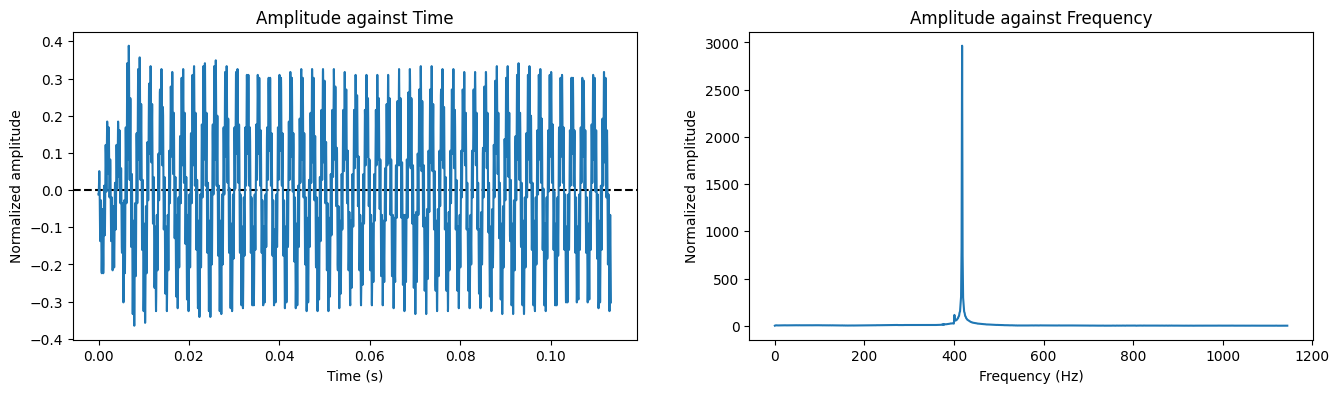

Shifted by 0 steps:


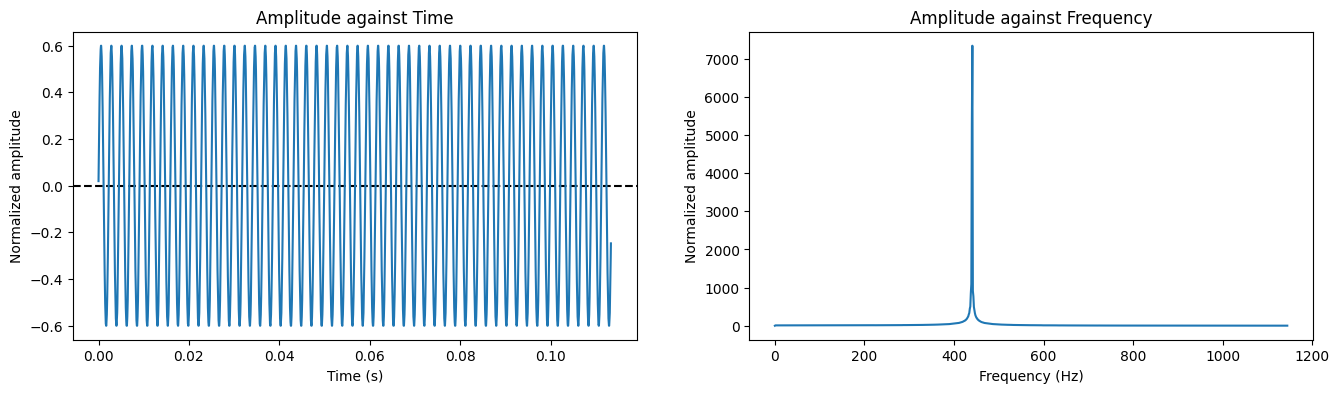

Shifted by 1 steps:


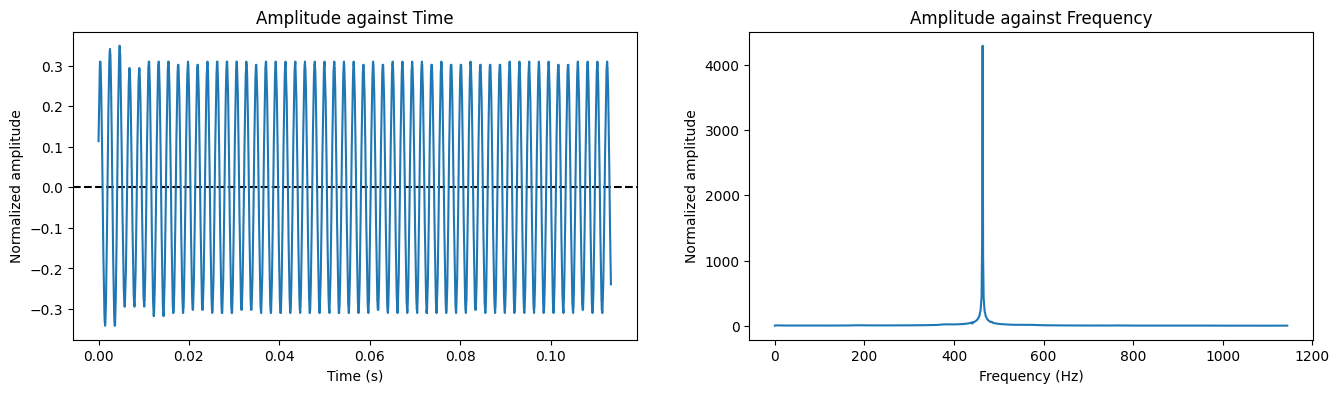

In [59]:
for file in os.listdir("demo/8-bit"):
    print(f"Shifted by {file.replace('.wav', '')} steps:")
    preview(f"demo/8-bit/{file}", amplitude_range=(0, 5000))

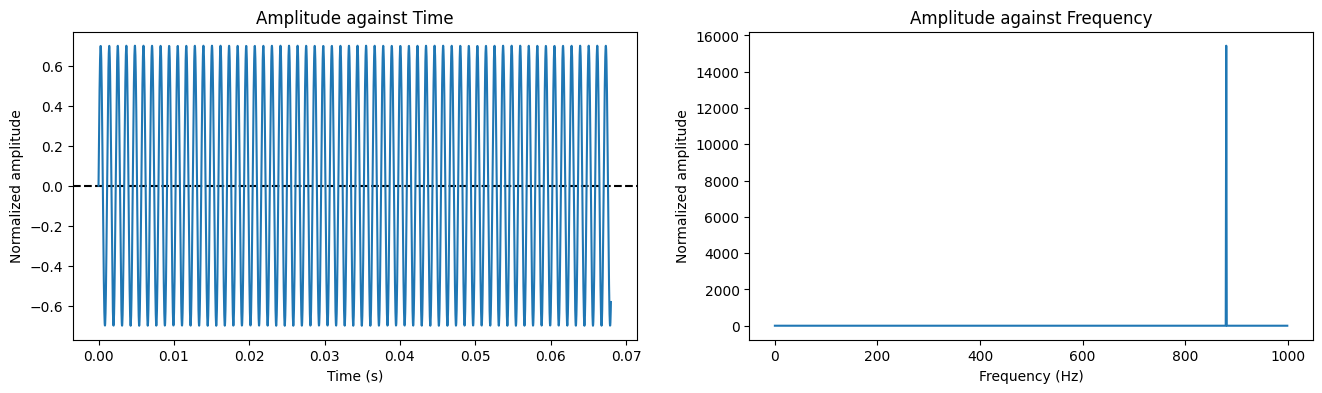

In [60]:
preview("samples/16-bit.wav", bits_per_sample=16, amplitude_range=(0, 3000))

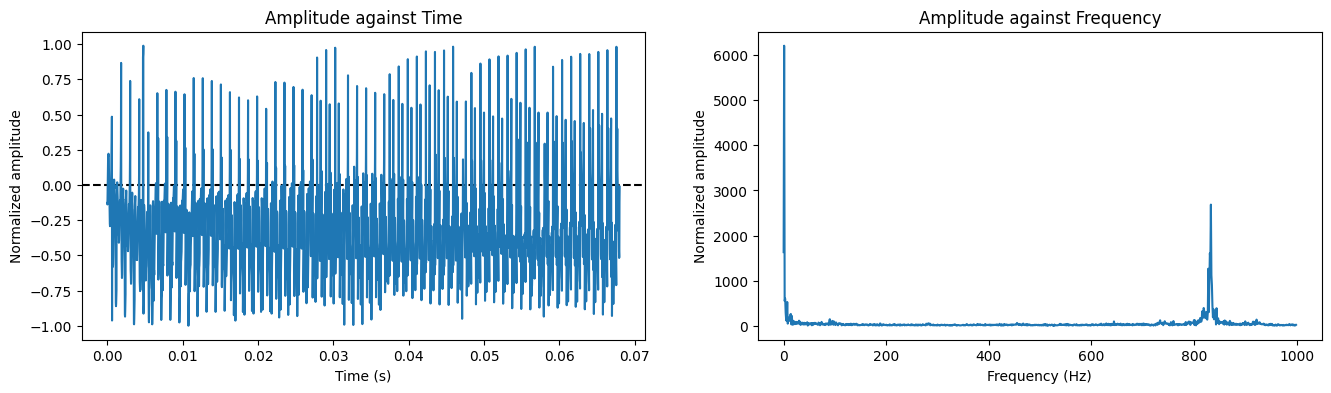

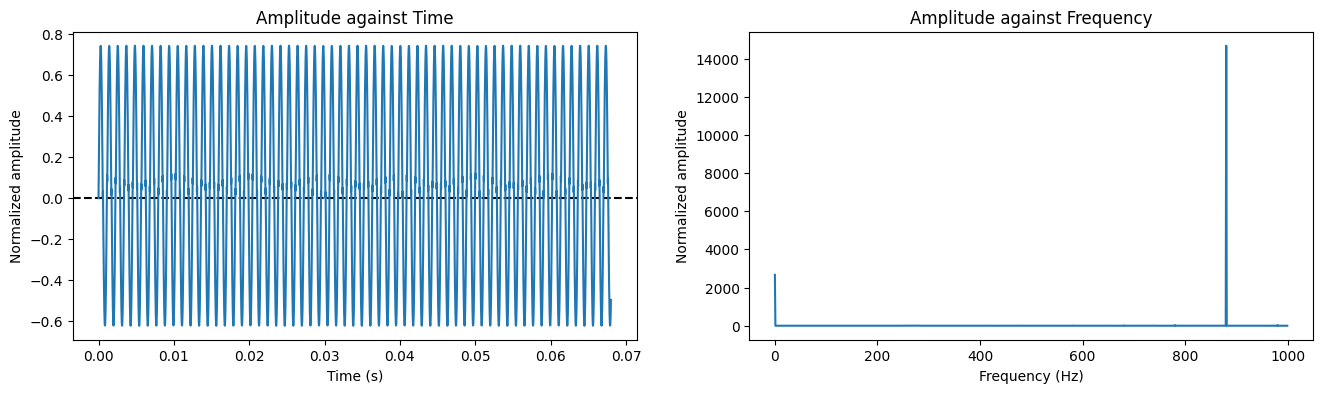

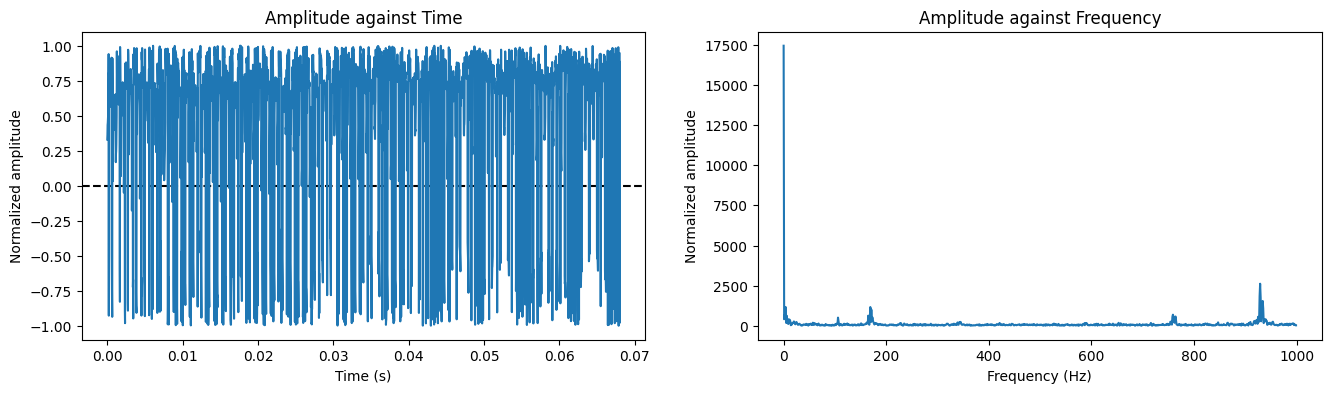

In [61]:
for file in os.listdir("demo/16-bit"):
    # print(f"Shifted by {file.replace('.wav', '')} steps``:")
    preview(f"demo/16-bit/{file}", bits_per_sample=16, amplitude_range=(0, 3000))